In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

2024-10-16 22:28:43.883591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 22:28:43.902582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 22:28:43.908292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 22:28:43.929251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 22:28:45.539389: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("/mnt/c/Users/mercg/Downloads/customer.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.drop('customerID',axis='columns',inplace=True)

In [4]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [5]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [6]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

/tmp/ipykernel_22052/973151263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [7]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

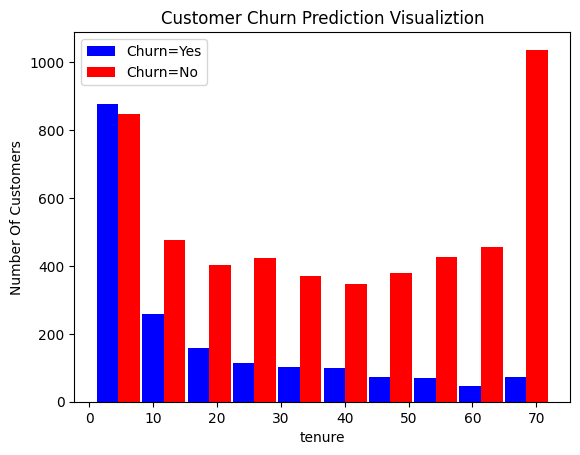

In [8]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

In [9]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 
                
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [10]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

/tmp/ipykernel_22052/2045096646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service','No',inplace=True)
/tmp/ipykernel_22052/2045096646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service','No',inplace=True)


In [11]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

/tmp/ipykernel_22052/1648037665.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
/tmp/ipykernel_22052/1648037665.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
/tmp/ipykernel_22052/1648037665.

In [12]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

/tmp/ipykernel_22052/698335744.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['gender'].replace({'Female':1,'Male':0},inplace=True)
/tmp/ipykernel_22052/698335744.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['gender'].replace({'Female':1,'Male':0},inplace=True)
/tmp/ipykernel_220

In [13]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

UNDERSAMPLING

In [14]:
count_class_0, count_class_1 = df1.Churn.value_counts()

# Divide by class
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

In [15]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
Churn
0    1869
1    1869
Name: count, dtype: int64


In [16]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [17]:
y_train.value_counts()

Churn
0    1495
1    1495
Name: count, dtype: int64

OVERSAMPLING

In [18]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
Churn
0    5163
1    5163
Name: count, dtype: int64


In [19]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [20]:
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

/home/mercg/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729097929.974130   22052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729097930.017785   22052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729097930.017901   22052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729097930.022274   22052 cuda_executor.cc:1001] could 

Epoch 1/100


I0000 00:00:1729097931.966684   22134 service.cc:146] XLA service 0x7fd94000c4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729097931.966741   22134 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-10-16 22:28:51.992632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 22:28:52.173091: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 59/259 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5782 - loss: 31.2691

I0000 00:00:1729097933.144764   22134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6318 - loss: 12.0584
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7072 - loss: 1.0102
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7143 - loss: 1.0174
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7207 - loss: 0.7598
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7377 - loss: 0.6618
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7245 - loss: 0.7300
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7352 - loss: 0.7215
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7204 - loss: 0.9562
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7186 - loss: 1.1107
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7370 - loss: 0.7062
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7251 - loss: 0.8520
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

SMOTE

In [21]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

X_sm.value_counts(), y_sm.value_counts()

(gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  PaperlessBilling  MonthlyCharges  TotalCharges  InternetService_DSL  InternetService_Fiber optic  InternetService_No  Contract_Month-to-month  Contract_One year  Contract_Two year  PaymentMethod_Bank transfer (automatic)  PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  PaymentMethod_Mailed check
 0       0              0        0           1       1             0              0               0             0                 0            0            0                1                 69.90           69.90         False                True                         False               True                     False              False              False                                    False                                  True                            False                         11
 1      

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, stratify=y_sm)

In [23]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


/home/mercg/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6004 - loss: 2.8695
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6846 - loss: 0.9885
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7061 - loss: 0.8598
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7201 - loss: 0.8433
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7010 - loss: 1.1022
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7292 - loss: 0.8161
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7190 - loss: 0.8422
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7115 - loss: 0.9572
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7330 - loss: 0.7472
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7273 - loss: 0.9109
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7386 - loss: 0.7864
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

ENSEMBLE UNDERSAMPLING

In [24]:
df2.Churn.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [25]:
X = df2.drop(columns='Churn')
y = df2['Churn']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [27]:
y_train.value_counts()

Churn
0    3872
1    1402
Name: count, dtype: int64

In [28]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [29]:
df3_c0 = df3[df3['Churn'] == 0]
df3_c1 = df3[df3['Churn'] == 1]

In [30]:
df3_c0.shape, df3_c1.shape

((3872, 27), (1402, 27))